# **Introduction**

Online food ordering has become a common part of everyday life. Customers interact with apps and platforms to order food, and their satisfaction is often reflected in the feedback they provide. Understanding the factors that influence **positive or negative feedback** can help businesses improve service quality and customer experience.

In this project, we are provided with customer demographic and geographic data, order status, and the feedback they gave after their order. Using this information, we aim to build a machine learning model that can **predict whether the feedback will be positive or negative**, based on customer characteristics and order details.

# **Business Understanding**

Customer feedback is a **critical metric** in the food delivery business. Positive feedback often reflects customer satisfaction, while negative feedback can indicate problems in the order process, delivery, or even user interface of the app.

By being able to **predict feedback before it happens**, the company could:

* Proactively **identify at-risk customers** who are likely to leave negative reviews.
* Improve **targeted customer service**, promotions, or follow-ups.
* Enhance the **recommendation engine** or user experience by understanding customer behavior.

Thus, turning feedback prediction into a data-driven process can lead to **better retention, higher satisfaction**, and **improved service quality**.

# **Goals**

The main goals of this project are:

1. **Build a machine learning model** that can predict whether a customer's feedback will be *positive* or *negative* based on their profile and order details.

2. **Evaluate the model** using performance metrics such as **accuracy** and **F1-score** to ensure the model performs well for both classes (especially since there might be class imbalance).


# **Data Understanding**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Preparation**

In [24]:
df = pd.read_csv('onlinefoods.csv')

In [25]:
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback,Unnamed: 12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes


In [26]:
df.shape # 388 rows, 13 columns

(388, 13)

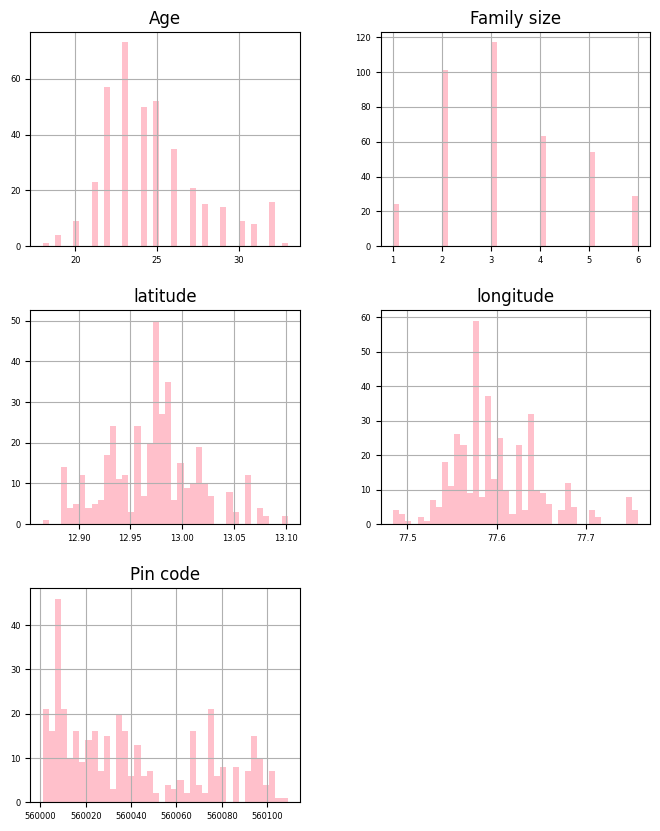

In [27]:
# data distribution before preprocessing
df.hist(figsize=(8, 10), bins=40, xlabelsize=6, ylabelsize=6, color='pink');

The **Age** distribution shows that most customers are young, mostly between 22 and 27 years old. The highest number of customers is around age 24. This means the model may learn more from younger users and might not work as well for older ones.

For **Family Size**, the most common number is 3, followed by 2, 4, and 5. This shows that customers come from families of different sizes, and this could affect their experience with food orders.

Looking at **Latitude** and **Longitude**, most customers are located in one specific area, likely from one city or region. The locations are quite concentrated, which might help the model understand the delivery environment and how it affects feedback.

The **Pin Code** distribution also shows that many customers are from a few popular areas, with a smaller number spread across other pin codes. This tells us that location plays an important role and can influence customer experience, possibly due to delivery times or service quality.

Overall, the data shows clear patterns and is mostly well distributed, though it leans more toward certain age groups and locations. These patterns are helpful for building a model, but we need to be careful about any bias that could affect the predictions.

## ***Check Duplicates***

In [28]:
df.duplicated().sum()

np.int64(103)

Normally, we might drop duplicate rows during preprocessing. But in this dataset, there are 103 duplicate rows out of 388, that’s more than 25%, which is a lot to lose, especially when we need enough data for training a machine learning model.
<br>
<br>
Also, there’s no clear identifier like an ID or name to tell if these duplicates are really the same person or just customers who share the same demographic and location data. So it’s possible that some customers legitimately appear more than once. Because of this, we decided **not to drop the duplicates for now**, so we don't accidentally remove useful patterns.



## ***Inconsistencies/Incorrect Data Types***

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly Income              388 non-null    object 
 5   Educational Qualifications  388 non-null    object 
 6   Family size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin code                    388 non-null    int64  
 10  Output                      388 non-null    object 
 11  Feedback                    388 non-null    object 
 12  Unnamed: 12                 388 non-null    object 
dtypes: float64(2), int64(3), object(8)


Above in a glance, we could summarize some procedure we must've done before training the data:

1. Drop columns for `Unnamed: 12` since we don't know what it used for (unknown purpose). So we need to get rid of it because keeping unnecessary or unclear columns can confuse the model and add noise to the data.
2. **Binary Encoding** convert to (0/1)
  * `Output` (yes/no)
  * `Feedback` (positve/negative)
3. **Ordinal Encoding** (they naturally have order)
  * `Monthly Income`
  * `Educational Qualifications`
4. **One-Hot Encoding** (unordered variable where we need to treat each of the answer equally)
  * `Gender`
  * `Marital Status`
  * `Occupation`
  * `Pin code`

> The reason we need to encode `Pin code` was because we cannot treat them as raw integer in this case. Eventho `Pin code` is a number, it doesn’t represent a numerical value with magnitude or order. For example, the difference between 560001 and 560009 has no numeric meaning, they are just codes for different geographic areas.

In [30]:
# before dropping 'Unnamed: 12' we could verified whether
# it was actually duplicated columns of 'output' variable

# check how many rows have the same value in both columns
matching_rows = (df['Output'] == df['Unnamed: 12']).sum()
total_rows = df.shape[0]

print(f"Matching rows: {matching_rows} / {total_rows}")

Matching rows: 388 / 388


In [31]:
# since it was indeed same exact column (copied) we could just drop it
df.drop('Unnamed: 12', axis=1, inplace=True)

In [32]:
df.shape # 388 rows, 12 columns since we drop 1 column

(388, 12)

In [33]:
# for every datatypes with 'objects' value_counts
for i in df.columns:
    if df[i].dtype == 'object':
        print(df[i].value_counts())
        print('-'*50)

Gender
Male      222
Female    166
Name: count, dtype: int64
--------------------------------------------------
Marital Status
Single               268
Married              108
Prefer not to say     12
Name: count, dtype: int64
--------------------------------------------------
Occupation
Student           207
Employee          118
Self Employeed     54
House wife          9
Name: count, dtype: int64
--------------------------------------------------
Monthly Income
No Income          187
25001 to 50000      69
More than 50000     62
10001 to 25000      45
Below Rs.10000      25
Name: count, dtype: int64
--------------------------------------------------
Educational Qualifications
Graduate         177
Post Graduate    174
Ph.D              23
School            12
Uneducated         2
Name: count, dtype: int64
--------------------------------------------------
Output
Yes    301
No      87
Name: count, dtype: int64
--------------------------------------------------
Feedback
Positive     3

We can briefly see that all of the unique values in the categorical columns are already clean and consistent in format. Because of this, we don't need to do any extra steps like cleaning or standardizing the text values.

In [34]:
df['Family size'].unique()

array([4, 3, 6, 2, 5, 1])

In [35]:
df['Pin code'].unique()

array([560001, 560009, 560017, 560019, 560010, 560103, 560042, 560048,
       560078, 560004, 560068, 560038, 560008, 560032, 560033, 560021,
       560085, 560050, 560098, 560003, 560066, 560034, 560102, 560025,
       560026, 560043, 560002, 560086, 560076, 560096, 560029, 560046,
       560030, 560024, 560020, 560028, 560064, 560036, 560011, 560061,
       560022, 560027, 560007, 560012, 560006, 560047, 560005, 560073,
       560016, 560013, 560051, 560015, 560018, 560109, 560023, 560104,
       560041, 560049, 560045, 560055, 560060, 560062, 560070, 560075,
       560080, 560092, 560095, 560097, 560093, 560091, 560100, 560079,
       560059, 560067, 560014, 560056, 560072])

The `Pin code` column in this dataset represents geographic regions (like postal codes), not numerical quantities. Even though it consists of numbers, the values don't carry a mathematical meaning. For example, a pin code of `560001` is not "less than" or "greater than" `560009` in a meaningful way. They are simply identifiers for different locations. Treating them as continuous numerical data could mislead the model into thinking there's an order or distance between them. So, it's more appropriate to handle them as **categorical variables**. Specifically, we should apply **one-hot encoding** so that each unique pin code is treated independently without assuming any inherent order or scale.


In [36]:
# convert 'Pin code' to string
df['Pin code'] = df['Pin code'].astype(str)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly Income              388 non-null    object 
 5   Educational Qualifications  388 non-null    object 
 6   Family size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin code                    388 non-null    object 
 10  Output                      388 non-null    object 
 11  Feedback                    388 non-null    object 
dtypes: float64(2), int64(2), object(8)
memory usage: 36.5+ KB


## ***Missing Values***

In [38]:
df.isna().sum()

,0
Age,0
Gender,0
Marital Status,0
Occupation,0
Monthly Income,0
Educational Qualifications,0
Family size,0
latitude,0
longitude,0
Pin code,0


No missing value here so we could ignore any imputation.

# **Exploratory Data Analysis**

## ***Correlation***

Text(0.5, 1.0, 'Numerical Features Correlation Heatmap')

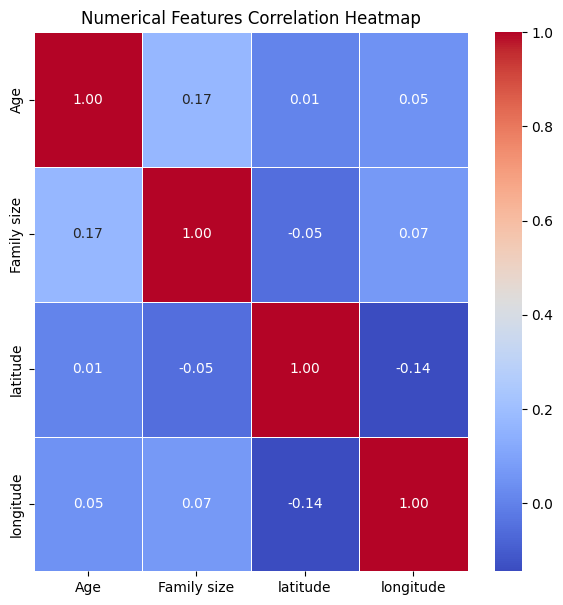

In [39]:
numeric_cols = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numeric_cols.append(col)

numeric_df = df[numeric_cols]

plt.figure(figsize=(7, 7))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Numerical Features Correlation Heatmap')

Most of the values are close to zero, meaning there is **very little to no strong correlation** between the features. The highest relationship is between `Age` and `Family Size` with a score of 0.17, but that's still weak. This means each feature is giving **different information**, and none of them are strongly linked.

## ***Numerical Distribution***

In [40]:
df.describe()

,Age,Family size,latitude,longitude
count,388.000000,388.000000,388.000000,388.000000
mean,24.628866,3.280928,12.972058,77.600160
std,2.975593,1.351025,0.044489,0.051354
min,18.000000,1.000000,12.865200,77.484200
25%,23.000000,2.000000,12.936900,77.565275
50%,24.000000,3.000000,12.977000,77.592100
75%,26.000000,4.000000,12.997025,77.630900
max,33.000000,6.000000,13.102000,77.758200


From the summary statistics, we can see that the average customer is around **24.6 years old**, with most falling between **23 and 26**. Family sizes range from **1 to 6**, with an average of **3.3 members**, showing a typical small to medium-sized household. For location, the latitude and longitude values show that customers are quite close together geographically, most likely from one city. The range is small, especially in latitude (from 12.86 to 13.10), which supports that they live in a concentrated area.


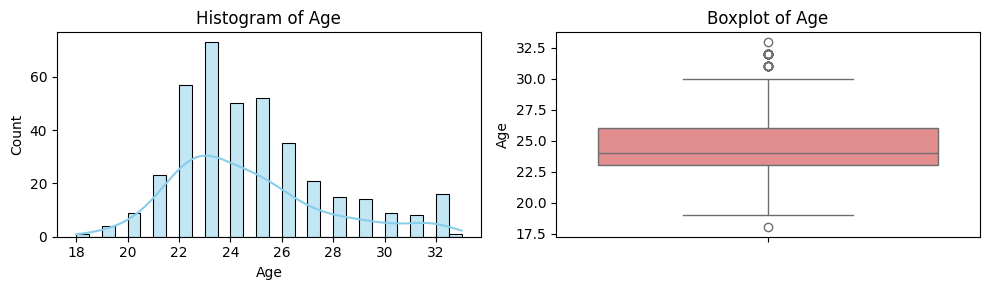

▶ Feature: Age
  Skewness: 0.8099
  Kurtosis: 0.2560
----------------------------------------


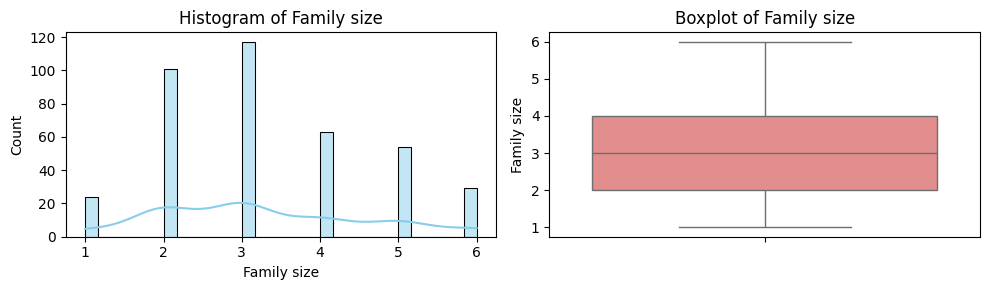

▶ Feature: Family size
  Skewness: 0.4014
  Kurtosis: -0.6635
----------------------------------------


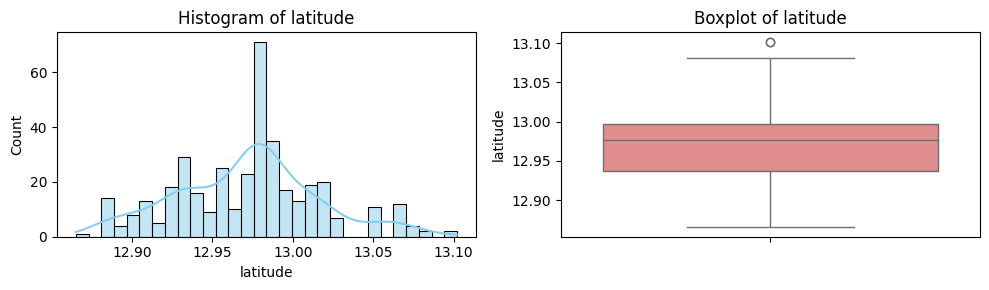

▶ Feature: latitude
  Skewness: 0.1603
  Kurtosis: 0.0306
----------------------------------------


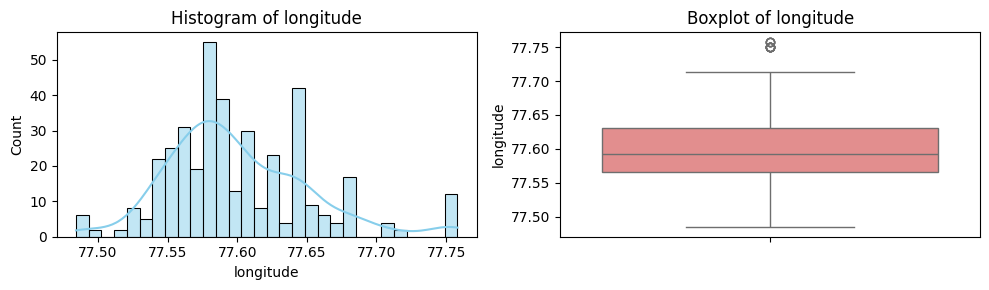

▶ Feature: longitude
  Skewness: 0.8020
  Kurtosis: 0.9845
----------------------------------------


In [41]:
target_col = 'Feedback'

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

def check_distribution_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30, kde=True, color='skyblue')
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col], color='lightcoral')
        plt.title(f'Boxplot of {col}')

        plt.tight_layout()
        plt.show()

        print(f"▶ Feature: {col}")
        print(f"  Skewness: {df[col].skew():.4f}")
        print(f"  Kurtosis: {df[col].kurt():.4f}")
        print("-" * 40)
check_distribution_outliers(df, numerical_cols)

The `Age` and `Longitude` values are a bit higher on one side, meaning most people are younger and live in certain areas, with just a few older people or outliers. `Family size` and `Latitude` look more balanced. Overall, the numbers are spread out quite normally, and nothing looks too extreme, so the data is okay to use without needing big fixes (no meaningful outliers to be treated).


/tmp/ipython-input-42-3237996276.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette='pastel', ax=axes[i])
/tmp/ipython-input-42-3237996276.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette='pastel', ax=axes[i])
/tmp/ipython-input-42-3237996276.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=target_col, y=col, palette='pastel', ax=axes[i])
/tmp/ipython-input-42-3237996276.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

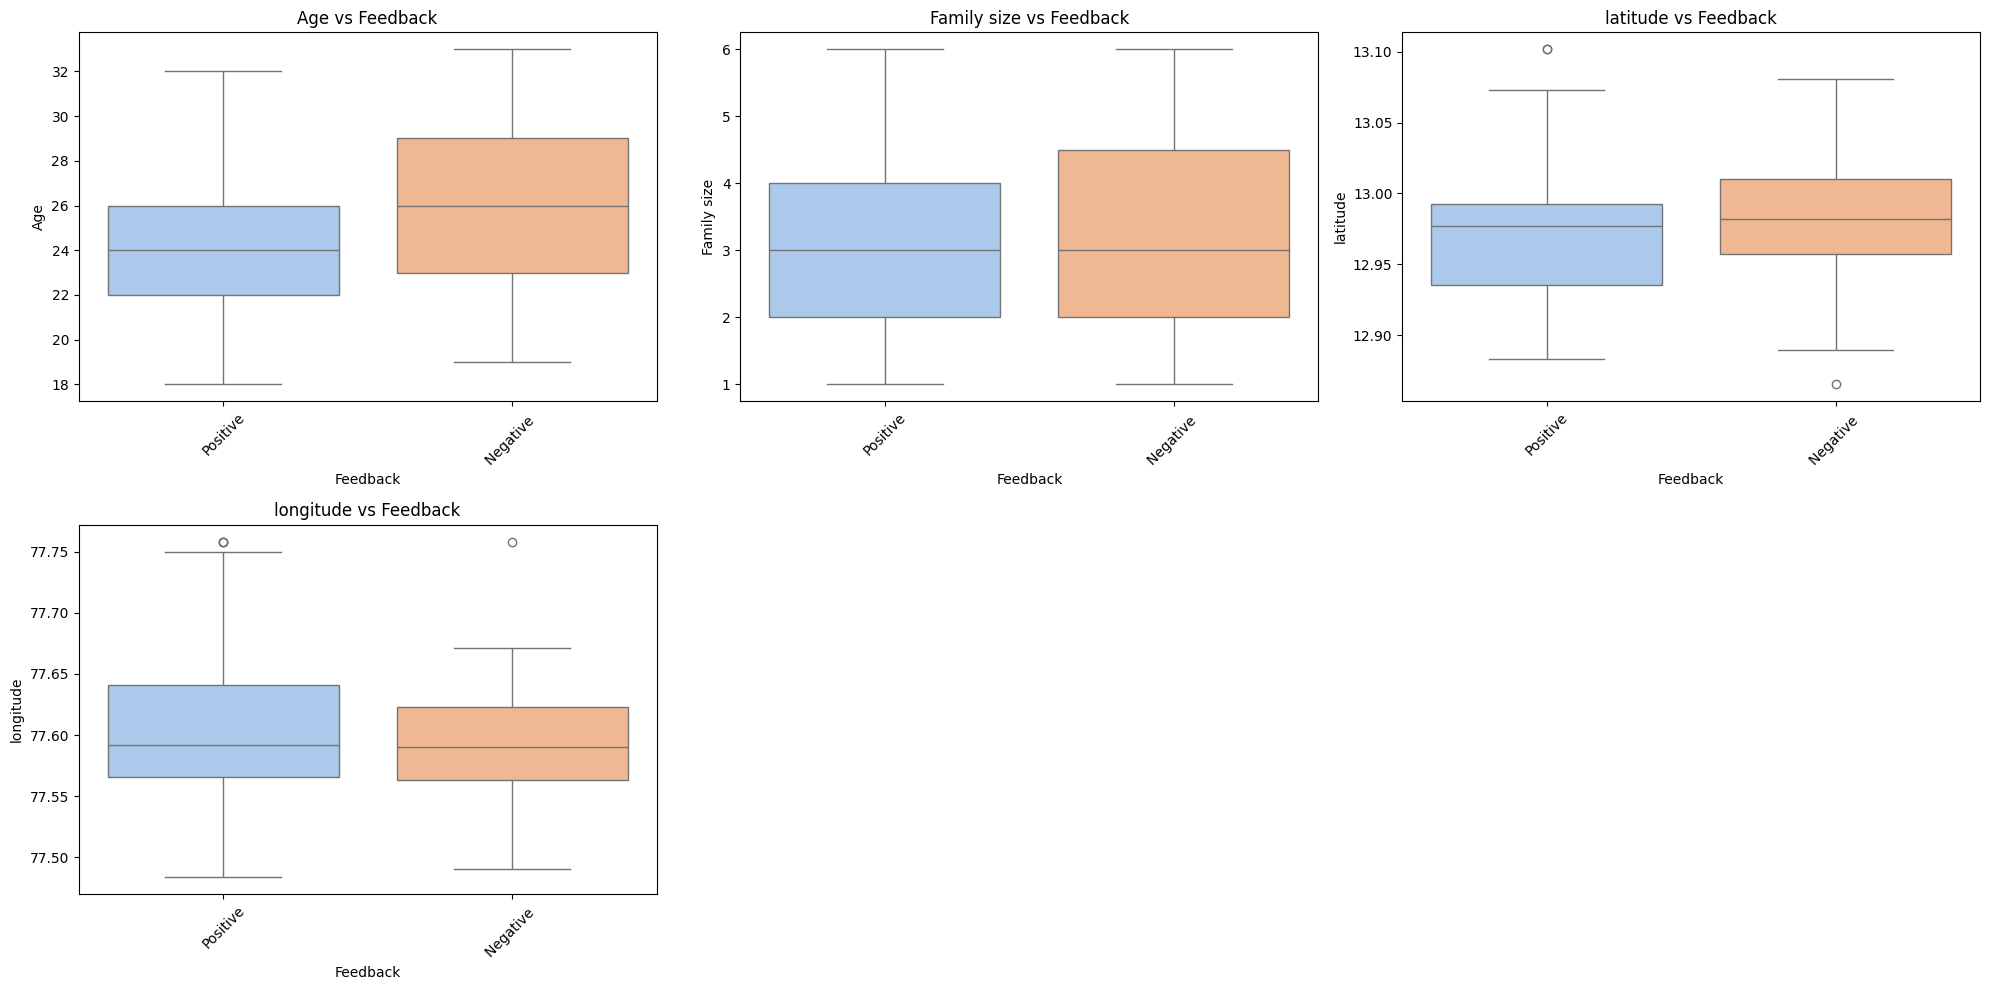

In [42]:
# numerical variables vs target
num_cols = len(numerical_cols)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x=target_col, y=col, palette='pastel', ax=axes[i])
    axes[i].set_title(f'{col} vs {target_col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From the `Age` boxplot, we can see that customers who gave **negative feedback tend to be slightly older** than those who gave positive feedback. `Family size` shows a similar pattern for both feedback types, so it might not strongly affect the result. For `latitude` and `longitude, the ranges are also quite similar, meaning **location does not seem to create a big difference** in feedback. Overall, **age may play a small role**, while the other numerical features don’t show strong separation between the two groups.


## ***Categorical Distribution***

/tmp/ipython-input-43-1462470074.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
/tmp/ipython-input-43-1462470074.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
/tmp/ipython-input-43-1462470074.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
/tmp/ipython-input-43-1462470074.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. 

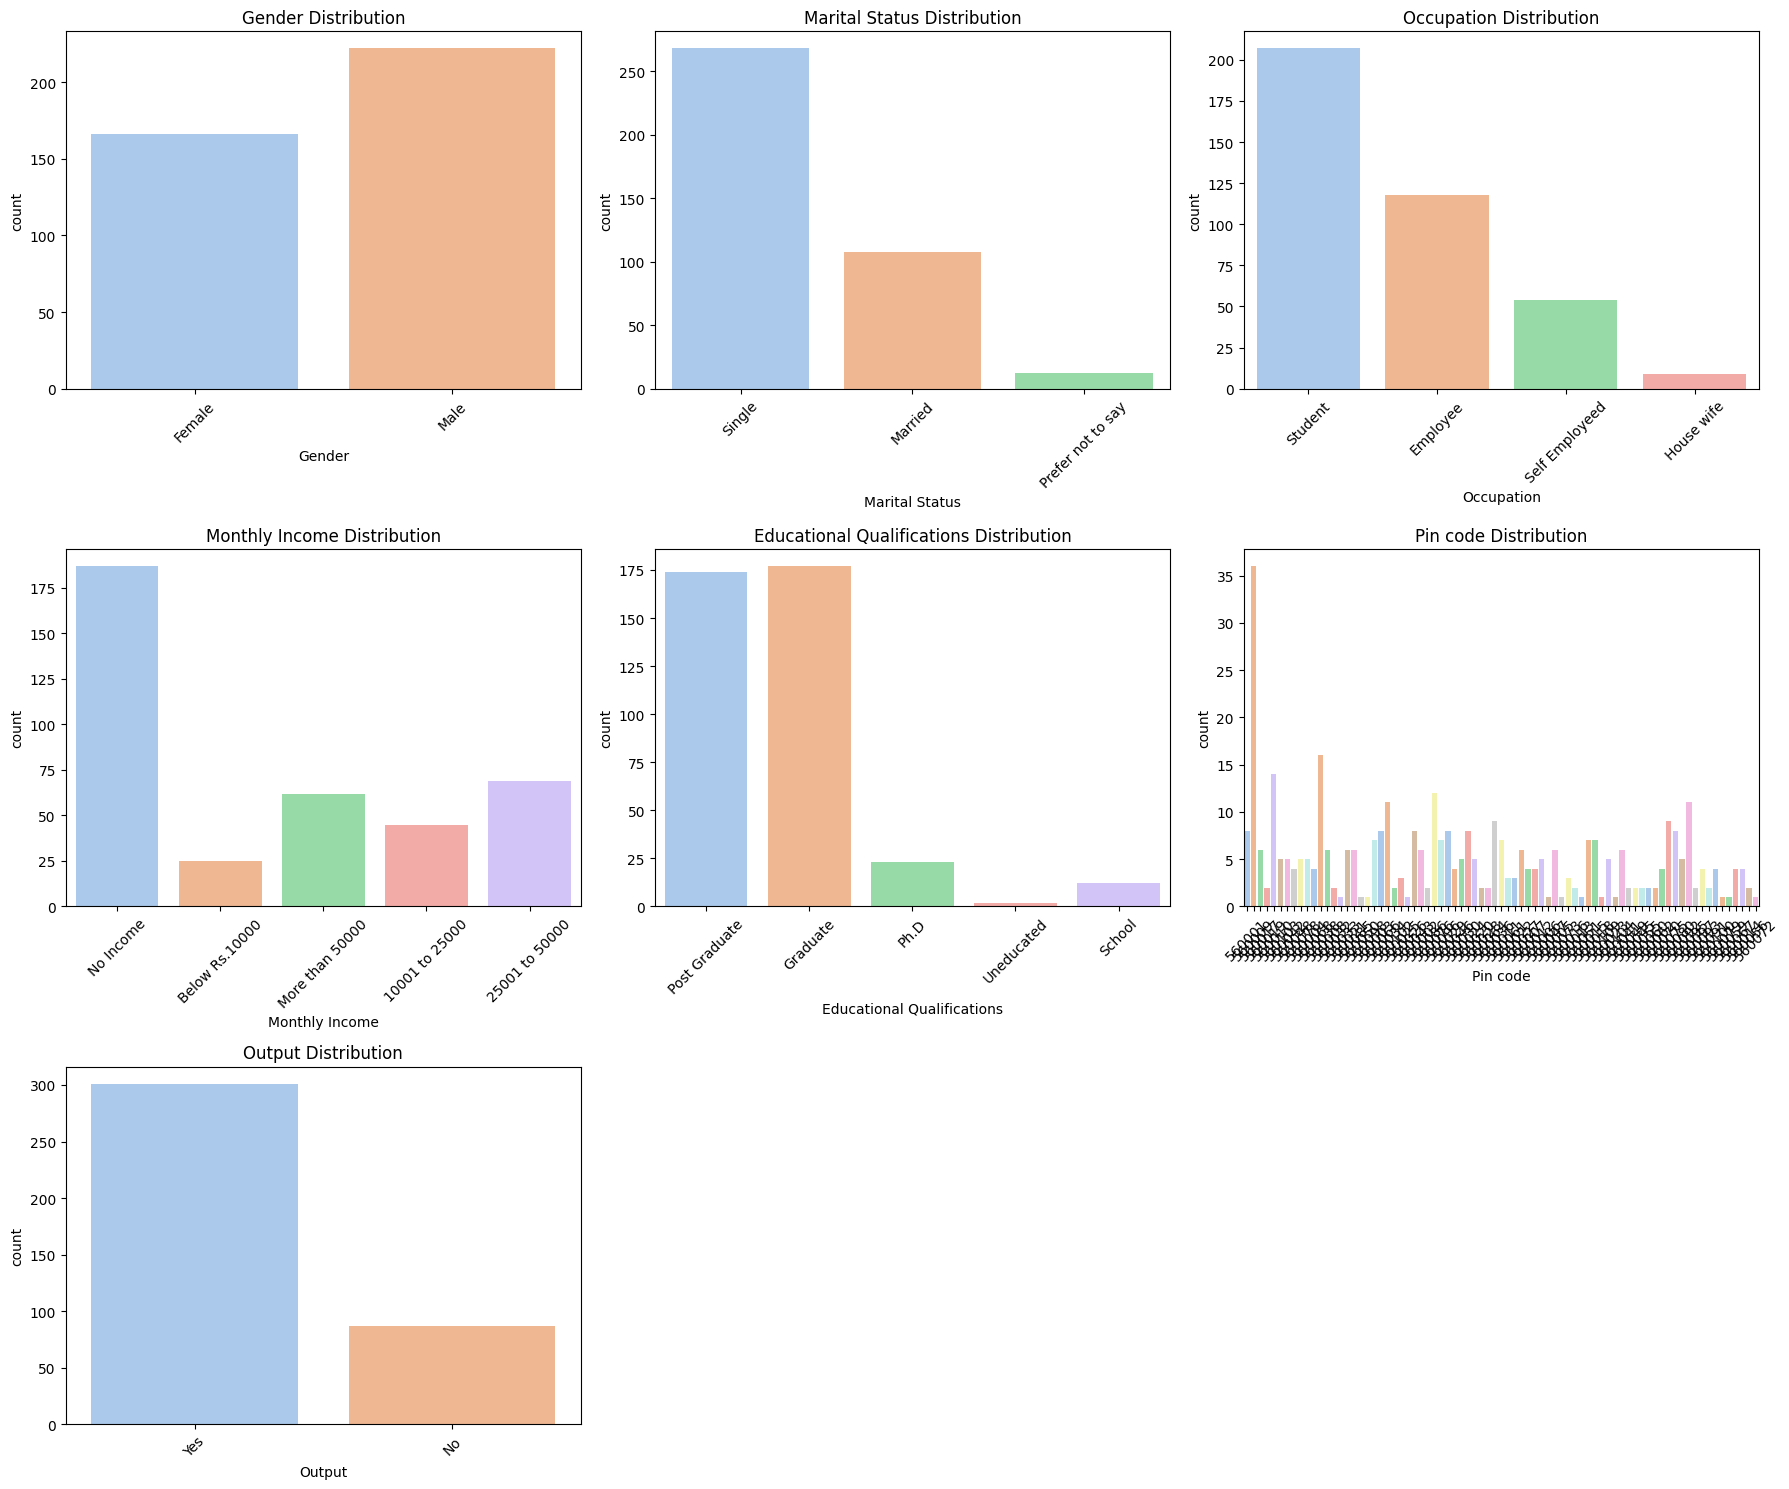

In [43]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols[categorical_cols != 'Feedback']
num_cols = len(categorical_cols)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, palette='pastel', ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We can see that most customers are **male, single, and students**. A large number of them have **no income**, and most are either **graduates or postgraduates**. The **pin code** distribution is quite spread out, but a few areas have noticeably more orders. For the **output status**, most orders are marked as "Yes", meaning they were likely confirmed or delivered. Overall, the data is **not balanced** across all categories, which might affect how the model learns, especially for smaller groups like “house wife” or “uneducated” which appear much less often.


/tmp/ipython-input-44-3706767053.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Feedback', palette='pastel')


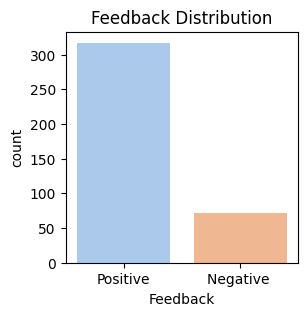

In [44]:
# target variable distribution
plt.figure(figsize=(3, 3))
sns.countplot(data=df, x='Feedback', palette='pastel')
plt.title('Feedback Distribution')
plt.show()

We can see that on our dataset, most customers gave **positive feedback**, while only a smaller portion gave **negative feedback**. This means the data is **unbalanced**, and the model might become too focused on predicting “positive” since it appears more often.

Because of this, we'll use the `class weighting approach` instead of `SMOTE`. Class weights let the model give more importance to the less common class (negative feedback) **without changing the original data**. This is simpler, avoids the risk of creating unrealistic synthetic data, and works well with models like **Random Forest or Logistic Regression**, which support class weights directly.

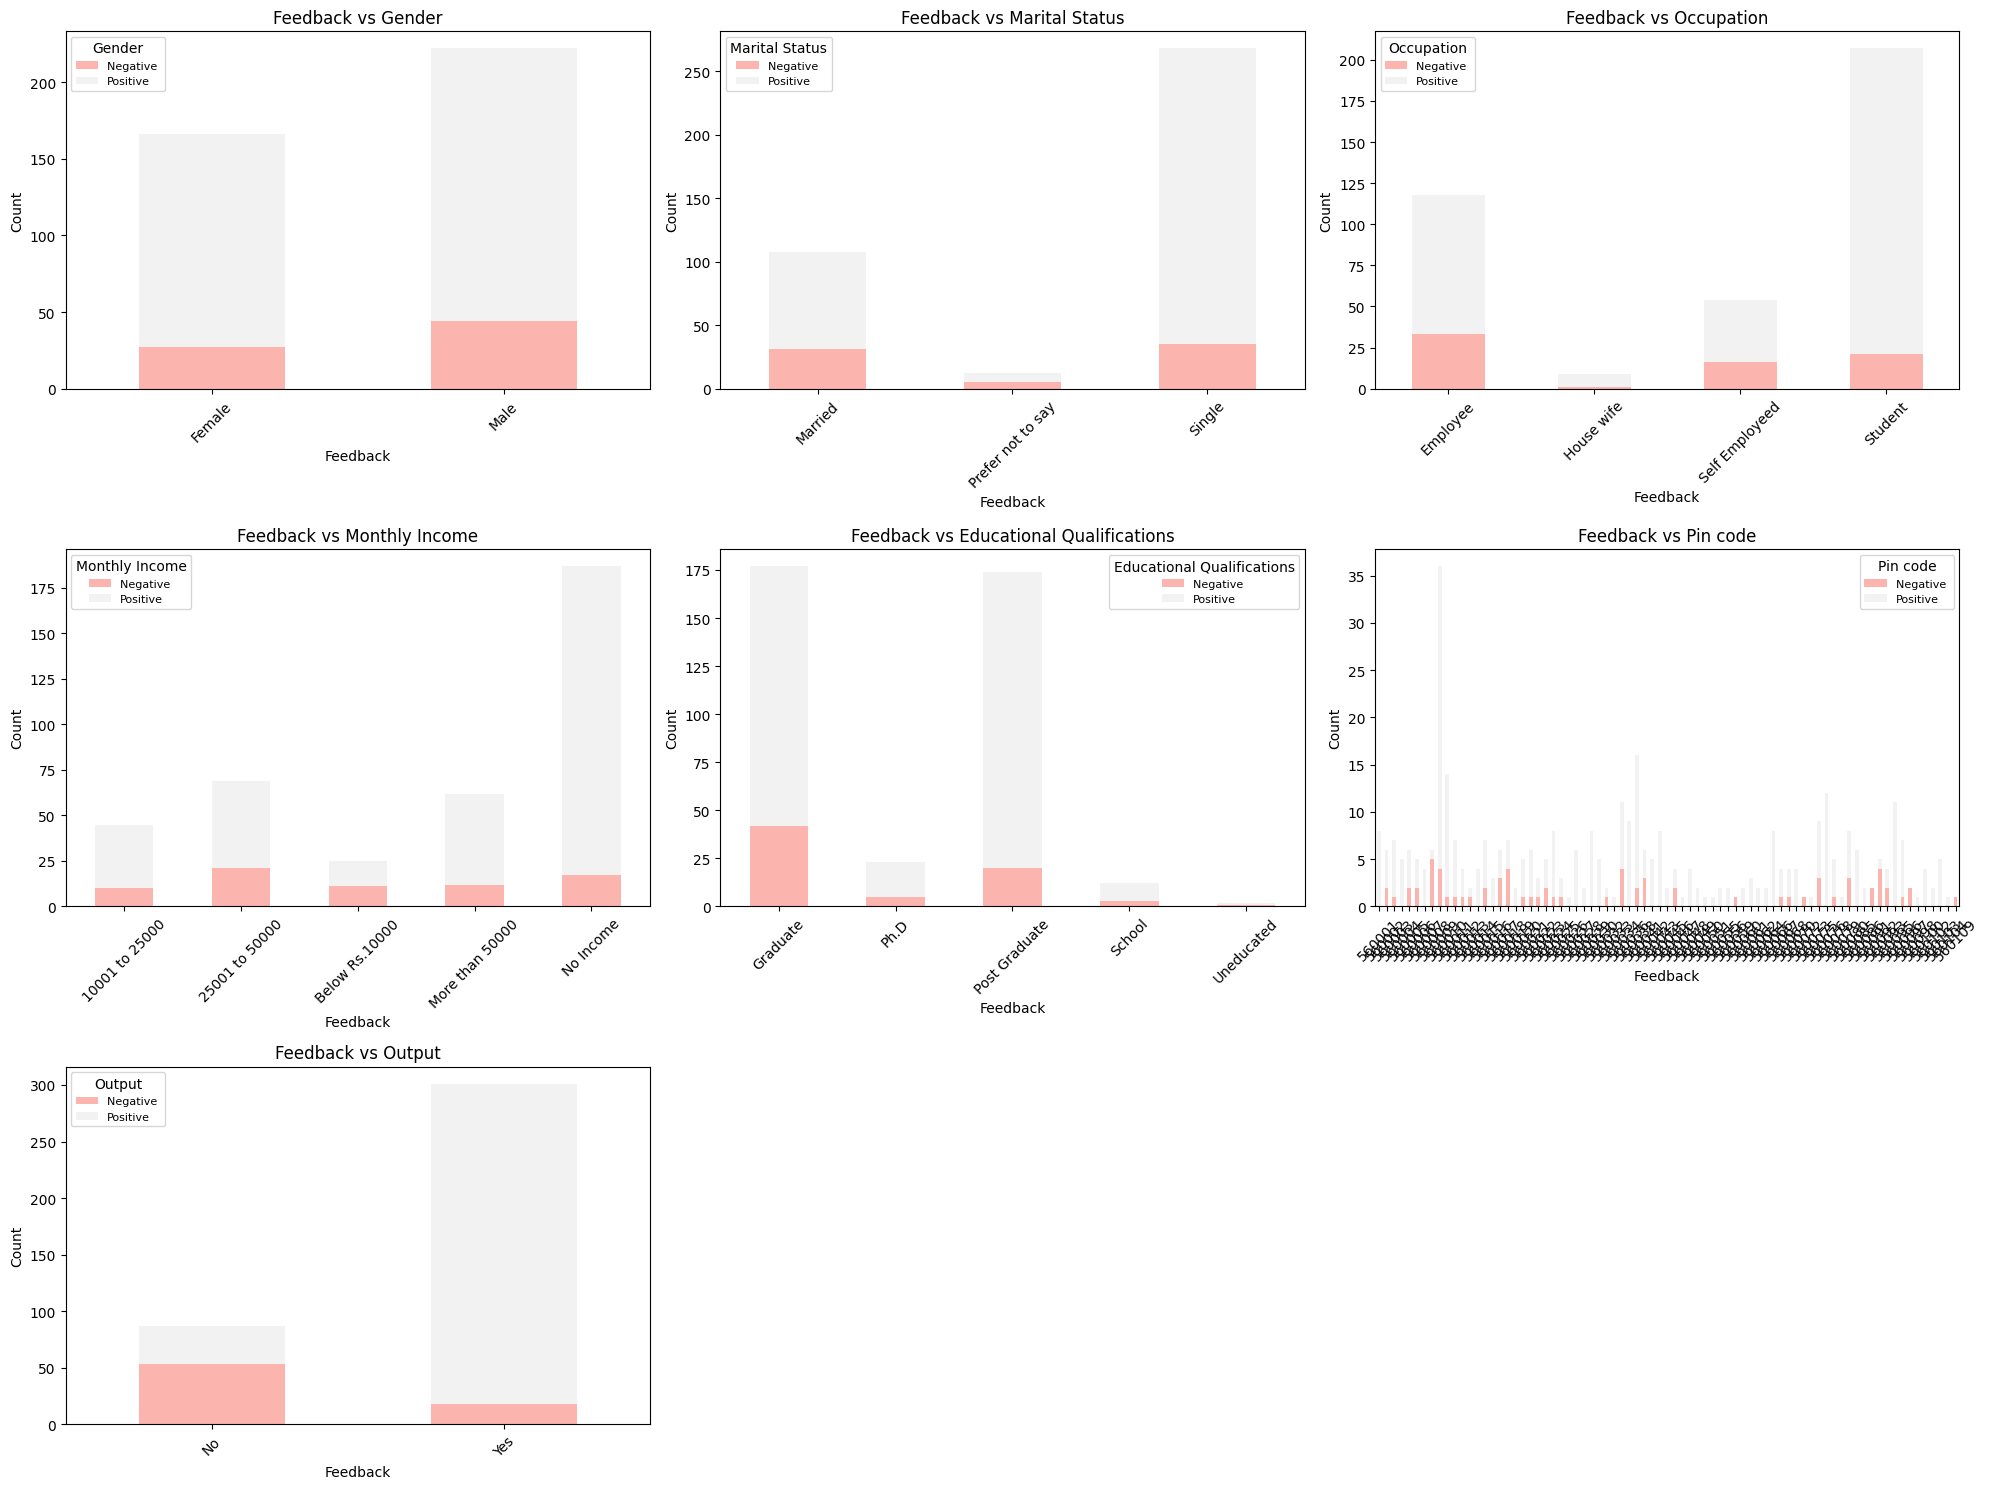

In [45]:
# categorical vs target
num_cols = len(categorical_cols)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ct = pd.crosstab(df[col], df[target_col])
    ct.plot(kind='bar', stacked=True, ax=axes[i], colormap='Pastel1')
    axes[i].set_title(f'{target_col} vs {col}')
    axes[i].set_xlabel(target_col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title=col, fontsize=8)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

This plot shows how different **categorical features** relate to the **feedback** given by customers. In almost every group, whether by gender, marital status, occupation, income, education, or pin code, **positive feedback dominates**. For example, both male and female customers mostly gave positive responses, and the same goes for students and people with no income. Even among different education levels like graduate or postgraduate, the pattern is similar.

While the **number of negative feedbacks is always lower**, it does appear slightly more often in some groups, like graduates, employees, and married customers. However, the overall trend stays the same: **positive feedback is much more common across all categories**, which supports the earlier finding that the dataset is unbalanced. These plots help us see that **no single category clearly explains the negative feedback**, meaning the model will likely need to learn from combinations of features rather than relying on just one.


# **Splitting Data**

In [46]:
print(df['Feedback'].unique())

['Positive' 'Negative ']


In [47]:
df['Feedback'] = df['Feedback'].map({'Negative ': 0, 'Positive': 1})

In [48]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Feedback'])
y = df['Feedback']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

We use `stratify=y` in the `train_test_split` function to make sure that the **proportion of positive and negative feedback** in the training and testing sets is the **same as in the original dataset**. Since our data is imbalanced, without stratification, we might randomly end up with **very few negative feedbacks** in the test set, which would make it hard to evaluate the model properly. Stratifying helps keep the class distribution balanced in both sets, so the model is trained and tested fairly.


# **Preprocessing**

## ***Scaling***

We use **Min-Max Scaler** to scale all the numerical features to a **fixed range between 0 and 1**. This ensures that all features contribute equally to the model, especially those that originally had different units or scales.



In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

## ***Encoding***

In [52]:
# binary/label encoding
X_train['Output'] = X_train['Output'].map({'No': 0, 'Yes': 1})
X_test['Output'] = X_test['Output'].map({'No': 0, 'Yes': 1})

Label Encoding turns categories into numbers. For example, `No` becomes `0`, and `Yes` becomes `1`.
<br>
<br>
**How it works:**
Each unique category is assigned an integer. It's simple but can cause problems if the model thinks the numbers have order or meaning (like `1` is greater than `0`), which they don’t.
<br>
<br>
**When to use:**
Only when the categories have a natural order (like `Low`, `Medium`, `High`), or with tree-based models that don’t care about numeric order.

In [53]:
# ordinal encoding
monthly_income_order = [
    'No Income',
    'Below Rs.10000',
    '10001 to 25000',
    '25001 to 50000',
    'More than 50000'
]

X_train['Monthly Income'] = X_train['Monthly Income'].astype(
    pd.CategoricalDtype(categories=monthly_income_order, ordered=True)
).cat.codes

X_test['Monthly Income'] = X_test['Monthly Income'].astype(
    pd.CategoricalDtype(categories=monthly_income_order, ordered=True)
).cat.codes


education_order = [
    'Uneducated',
    'School',
    'Graduate',
    'Post Graduate',
    'Ph.D'
]

X_train['Educational Qualifications'] = X_train['Educational Qualifications'].astype(
    pd.CategoricalDtype(categories=education_order, ordered=True)
).cat.codes

X_test['Educational Qualifications'] = X_test['Educational Qualifications'].astype(
    pd.CategoricalDtype(categories=education_order, ordered=True)
).cat.codes

Similar to Label Encoding, but used **only when the order matters**.
<br>
<br>
**How it works:**
It assigns numbers based on a **ranking**. For example:

* `Uneducated` = 0
* `School` = 1
* `Graduate` = 2
* `Post Graduate` = 3
* `Ph.D` = 4
<br>
<br>

**When to use:**
When the categories have a **clear ranking or level**, like education level or customer satisfaction (`Poor`, `Average`, `Good`).

In [54]:
# one hot
from sklearn.preprocessing import OneHotEncoder

nom_cols = ['Gender', 'Marital Status', 'Occupation', 'Pin code']
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# TRAIN SET
ohe_encoder.fit(X_train[nom_cols])
train_encoded = ohe_encoder.transform(X_train[nom_cols])
train_encoded_df = pd.DataFrame(train_encoded, columns=ohe_encoder.get_feature_names_out(nom_cols), index=X_train.index)
# replace original nominal columns with encoded ones
X_train = pd.concat([X_train.drop(nom_cols, axis=1), train_encoded_df], axis=1)

# TEST SET
test_encoded = ohe_encoder.transform(X_test[nom_cols])
test_encoded_df = pd.DataFrame(test_encoded, columns=ohe_encoder.get_feature_names_out(nom_cols), index=X_test.index)

X_test = pd.concat([X_test.drop(nom_cols, axis=1), test_encoded_df], axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


It turns categories into **separate columns** with 0s and 1s.
<br>
<br>
**How it works:**
For example, the column “Gender” becomes two columns: `Gender_Male` and `Gender_Female`. If the person is male, `Gender_Male = 1`, `Gender_Female = 0`.
<br>
<br>
**When to use:**
Best for categorical features with **no natural order**, like gender, occupation, or city. Avoid using it with too many unique values (like 100+ cities), because it creates too many columns.

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((310, 87), (78, 87), (310,), (78,))

# **Build Model**

We are going to use **class imbalance handling** (like class weights or special parameters) on every model we build. This is because our data has **more positive feedback than negative**, and without adjustment, the models might just learn to predict everything as positive. By applying class imbalance techniques, we help the models **pay more attention to the less common class**, so they can make better and fairer predictions for both positive and negative feedback.

In [67]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

To predict customer feedback, we need models that can understand patterns in people's information, like their age, job, income, and where they live.

1. We use **Random Forest** because it can handle different types of customer data (like numbers and categories) and can figure out complex patterns, such as which combinations of age, job, or family size are linked to positive or negative feedback.
<br>
<br>
2. **XGBoost** is chosen because it's very good at finding even small patterns in the data. It helps us understand which details really affect customer satisfaction, like whether income or order status matters more for feedback.
<br>
<br>
3. We include **Logistic Regression** because it's simple and helps us clearly see which features push a customer toward giving positive or negative feedback. It's also fast and works well as a basic comparison.
<br>
<br>
4. **K-Nearest Neighbors (KNN)** is useful because it looks at similar customers and guesses feedback based on what those similar people did. For example, if most students with low income gave positive feedback, it will likely predict the same for a similar new person.
<br>
<br>
5. Finally, **Support Vector Machine (SVM)** helps separate the two types of feedback by drawing a clear line between them. It’s especially good when the feedback depends on a mix of many features working together.
<br>
<br>
By using these models, we can find out which one best understands what leads a customer to give positive or negative feedback, so we can make accurate and fair predictions based on their profile.

## ***Random Forest***

Random Forest is like a **team of decision trees** that work together to make better predictions. Each tree looks at different parts of the data and makes its own guess (for example: whether the feedback is positive or negative). Then, the forest takes a **vote** from all the trees to decide the final prediction. Because it uses many trees instead of just one, it's more accurate and less likely to make random mistakes.
<br>
<br>
Random Forest is great for data like this because it can handle both numbers (like age or income) and categories (like gender or job), and it doesn't get confused by outliers or missing patterns.



In [56]:
# RANDOM FOREST
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# hyperparameter grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', 0.8]
}

# GridSearchCV
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2', 0.8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

* **`n_estimators`**: This is the number of trees in the forest. More trees usually mean better results, but they also take more time to train. We're testing 100, 200, and 300 trees.

* **`max_depth`**: This controls how deep each tree can grow. Deeper trees can learn more detail, but they can also overfit.

* **`min_samples_split`**: This is the minimum number of samples needed to split a node in a tree. Higher values make the model simpler, and lower values let it grow more complex.

* **`criterion`**: This decides how the model measures “purity” when it splits data in a tree. We're testing `'gini'`, `'entropy'`, and `'log_loss'` all are methods to choose the best question at each step.

* **`max_features`**: This decides how many features (columns) each tree should look at when making splits. You're testing `'sqrt'`, `'log2'`, and `0.8` (meaning 80% of features). This helps keep the trees diverse.



## ***Extreme Gradient Boost***

**XGBoost** is a powerful model that builds a series of small decision trees, one after another. Each new tree tries to fix the mistakes made by the previous trees. It keeps improving the model step by step until the predictions are as accurate as possible. This process is called **boosting**, boosting the model's performance by learning from its own errors.
<br>
<br>
XGBoost is great at finding patterns in structured data like customer profiles. It also has built-in ways to handle **imbalanced classes**, which is why we use `scale_pos_weight` to help it pay more attention to the less common feedback (negative feedback).


In [57]:
from collections import Counter

# calculate scale_pos_weight
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]  # assuming 1 = minority class ('Negative')

# XGBOOST
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# hyperparameter grid
xgb_params = {
   'max_depth': [3, 6, 10],
   'learning_rate': [0.01, 0.05, 0.1, 0.2],
   'n_estimators': [50, 100, 200],
   'subsample': [0.6, 0.8, 1.0],
   'gamma': [0, 0.1, 0.2]
}

# GridSearchCV
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:54:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy')

Instead of using `class_weight` like in some other models, **XGBoost** handles class imbalance using a parameter called **`scale_pos_weight`**. This parameter controls how much attention the model gives to the **positive class** (label `1`) during training. By default, `scale_pos_weight = 1`, which means the model treats both classes as equally important, regardless of how imbalanced they are.
<br>
<br>
However, in imbalanced datasets like ours, where one class (positive feedback) appears much more often than the other, this default setting isn't ideal. To address this, we can **manually calculate the proper weight** by dividing the number of samples in the **majority class** by the number in the **minority class**. The formula is:

```
scale_pos_weight = number of negative samples / number of positive samples
```

This adjustment tells the model to give more importance to the minority class, helping it learn to detect it better during training. It's especially helpful when accuracy alone might hide poor performance on the less common class.

* **`max_depth`**: This sets how deep each tree can grow. Deeper trees can learn more details, but may also overfit. Y

* **`learning_rate`**: This controls how much each new tree corrects the mistakes of the previous ones. Smaller values (like 0.01 or 0.05) make learning slower but safer, while larger values (like 0.2) make learning faster but risk overfitting.

* **`n_estimators`**: This is the number of trees to build. More trees often give better results, as long as they don’t overfit.

* **`subsample`**: This tells the model how much of the training data to use for each tree. Using less than 100% (like 0.6 or 0.8) can prevent overfitting and make the model more general.

* **`gamma`**: This controls how much the model needs to improve before it splits a node. Higher values make the model more conservative and less complex.


## ***Logistic Regression***

**Logistic Regression** is a basic but powerful model that tries to draw a clear line between two groups, in this case, **positive vs. negative feedback**. It looks at the features (like age, income, or order status) and tries to find a formula that calculates the **probability** of a customer giving positive or negative feedback. If the result is more than 50%, it predicts one class; otherwise, the other.
<br>
<br>
Even though it’s simple, it’s very effective and easy to interpret. It also trains very fast, which is helpful when you're testing many models.
<br>
<br>
We also added `class_weight='balanced'` to make sure it gives **fair attention to both classes**, especially since positive feedback is much more common in the dataset.


In [60]:
# LOGISTIC REGRESSION
log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

# hyperparameter grid
log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# GridSearchCV
log_reg_grid = GridSearchCV(log_reg, log_reg_params, cv=3, scoring='accuracy', n_jobs=-1)
log_reg_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy')

* **`penalty`**: This tells the model how to control complexity and avoid overfitting.

  * `'l1'` (Lasso) can shrink some feature weights to zero (automatic feature selection).
  * `'l2'` (Ridge) keeps all features but makes their weights smaller and more stable.

* **`C`**: This controls how much penalty we apply.

  * A smaller `C` means more regularization (stricter model).
  * A larger `C` means less regularization (more freedom to fit the data).

* **`solver`**: We use `'liblinear'` because it supports both `'l1'` and `'l2'` penalties and works well for smaller datasets like ours.

* **`class_weight`**: We're testing both `None` and `'balanced'` to see if the model performs better when we **force it to pay attention to the minority class** (negative feedback).



## ***K-Nearest Neighbors***

**K-Nearest Neighbors** is a model that makes predictions based on **similarity**. When we want to predict whether a customer will give positive or negative feedback, KNN looks at the **most similar customers** (neighbors) in the training data. It checks what feedback those neighbors gave and makes a guess based on the majority.
<br>
<br>
For example, if most of the nearby customers (with similar age, income, or occupation) gave positive feedback, KNN will predict that the new customer will also give positive feedback. It’s simple and works well when similar customers tend to behave the same.



In [62]:
# K NEAREST NEIGHBORS
knn = KNeighborsClassifier()

# hyperparameter grid
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],  # 'distance' gives more weight to closer neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2]  # only used with minkowski (1=manhattan, 2=euclidean)
}

# GridSearchCV
knn_grid = GridSearchCV(knn, knn_params, cv=3, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski',
                                    'chebyshev'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

* **`n_neighbors`**: This decides how many neighbors to check. Fewer neighbors (like 3) can react more to small changes, while more neighbors (like 15) make more stable predictions.

* **`weights`**:

  * `'uniform'` treats all neighbors equally.
  * `'distance'` gives more importance to closer neighbors, meaning nearer customers affect the prediction more than farther ones.

* **`metric`**: This controls how “distance” is calculated between customers.

  * `'euclidean'` (straight-line distance)
  * `'manhattan'` (like walking on city blocks)
  * `'minkowski'` is a general form that includes both
  * `'chebyshev'` measures the maximum difference across all features

* **`p`**: Used only with `minkowski` to define its behavior.

  * `p=1` = manhattan distance
  * `p=2` = euclidean distance


KNN is a useful model here because it gives predictions based on **real customer behavior**, not just mathematical formulas. It helps us understand how much a customer’s profile is like others who gave certain types of feedback.


## ***Support Vector Machine***

**SVM (Support Vector Machine)** tries to find the **best boundary** (a line or curve) that separates the two groups, in this case, customers who gave **positive** feedback and those who gave **negative**. It looks for the line that's as far away as possible from both groups, so that new data points can be classified with confidence.
<br>
<br>
SVM is useful for feedback prediction because it works well even when the data isn't perfectly separated. It can also handle **complex relationships** between features using different kernel types. And with `class_weight='balanced'`, it gives fair attention to both feedback classes, which is important since our data is imbalanced.



In [65]:
# SVM
svm = SVC(probability=True, random_state=42, class_weight='balanced')

# hyperparameter grid
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.5, 1.0]
}

# GridSearchCV
svm_grid = GridSearchCV(svm, svm_params, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'coef0': [0.0, 0.5, 1.0],
                         'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

* **`C`**: Controls how strict the model is about correctly classifying every training point.

  * Small `C` = simpler model (allows some mistakes)
  * Large `C` = stricter model (tries to get everything right, but may overfit)

* **`kernel`**: Determines the type of boundary the model can learn.

  * `'linear'`: draws a straight line
  * `'rbf'`: draws curved boundaries (good for complex data)
  * `'poly'`: fits polynomial curves (controlled by `degree`)
  * `'sigmoid'`: similar to a neural network activation, for special cases

* **`gamma`**: Only used for non-linear kernels like `'rbf'`, `'poly'`, and `'sigmoid'`.

  * Controls how far the influence of a single data point reaches.
  * Low gamma = smoother, wider curves
  * High gamma = tight, more sensitive curves

* **`degree`**: Used only for `'poly'` kernel. Higher degree = more complex curves.

* **`coef0`**: Used for `'poly'` and `'sigmoid'` kernels. It adjusts the shape of the decision boundary (like adding a constant shift).


# **Evaluation**

In [66]:
models = {
    'Random Forest': rf_grid,
    'XGBoost': xgb_grid,
    'Logistic Regression': log_reg_grid,
    'KNN': knn_grid,
    'SVM': svm_grid
}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
🔍 Model: Random Forest
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
📊 Accuracy     : 0.8846
📊 F1 Score     : 0.9302
📊 ROC AUC      : 0.8884

📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.64      0.67        14
    Positive       0.92      0.94      0.93        64

    accuracy                           0.88        78
   macro avg       0.81      0.79      0.80        78
weighted avg       0.88      0.88      0.88        78



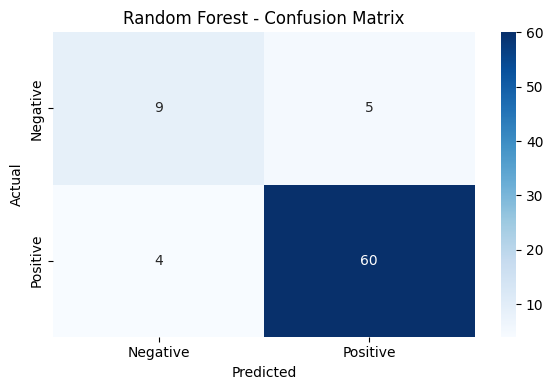

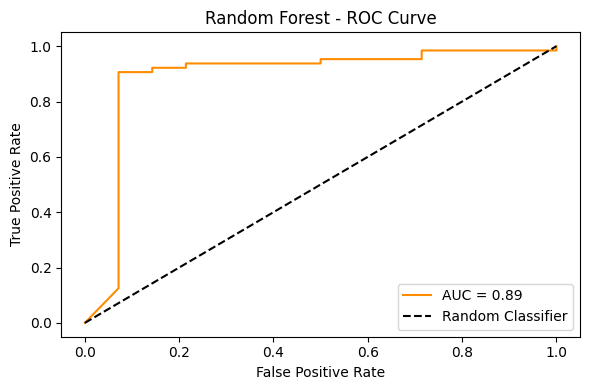

Best Hyperparameters:
   • criterion: gini
   • max_depth: 10
   • max_features: 0.8
   • min_samples_split: 10
   • n_estimators: 300


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
🔍 Model: XGBoost
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
📊 Accuracy     : 0.8462
📊 F1 Score     : 0.9032
📊 ROC AUC      : 0.8817

📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.71      0.62        14
    Positive       0.93      0.88      0.90        64

    accuracy                           0.85        78
   macro avg       0.74      0.79      0.76        78
weighted avg       0.87      0.85      0.85        78



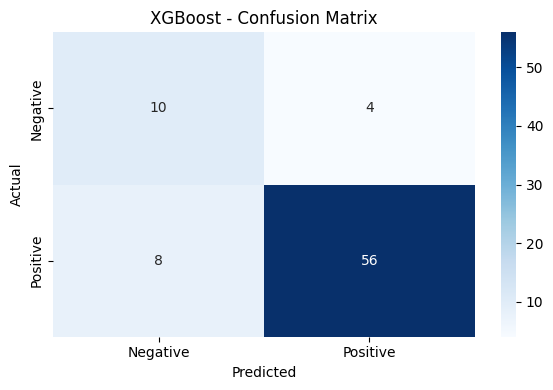

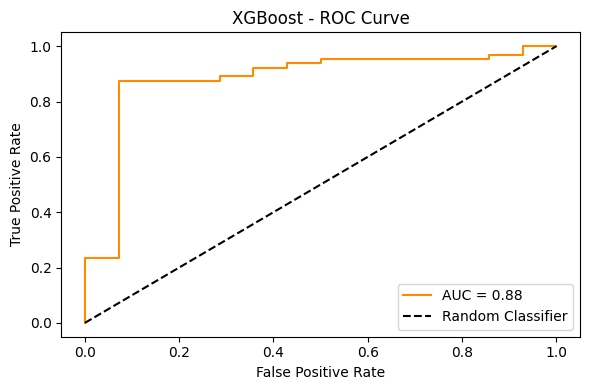

Best Hyperparameters:
   • gamma: 0
   • learning_rate: 0.05
   • max_depth: 6
   • n_estimators: 100
   • subsample: 0.6


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
🔍 Model: Logistic Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
📊 Accuracy     : 0.8718
📊 F1 Score     : 0.9194
📊 ROC AUC      : 0.8733

📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.61      0.79      0.69        14
    Positive       0.95      0.89      0.92        64

    accuracy                           0.87        78
   macro avg       0.78      0.84      0.80        78
weighted avg       0.89      0.87      0.88        78



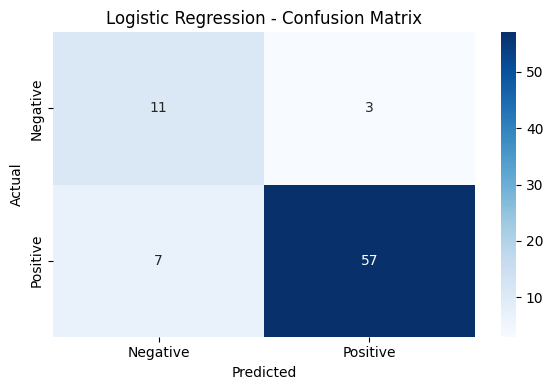

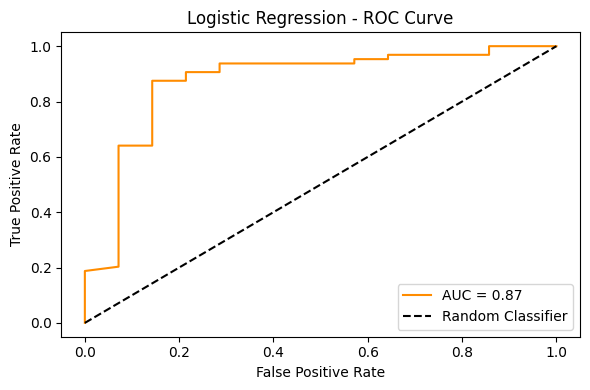

Best Hyperparameters:
   • C: 1
   • class_weight: balanced
   • penalty: l1
   • solver: liblinear


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
🔍 Model: KNN
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
📊 Accuracy     : 0.8590
📊 F1 Score     : 0.9173
📊 ROC AUC      : 0.8175

📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.43      0.52        14
    Positive       0.88      0.95      0.92        64

    accuracy                           0.86        78
   macro avg       0.78      0.69      0.72        78
weighted avg       0.85      0.86      0.85        78



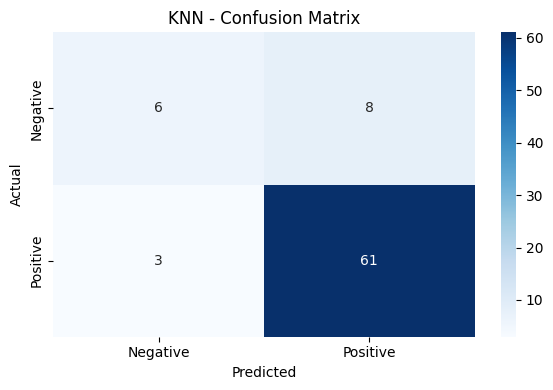

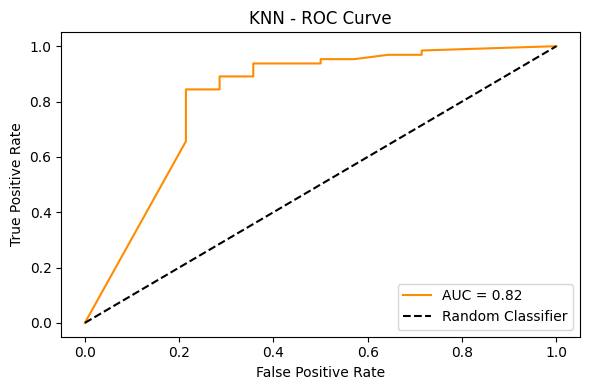

Best Hyperparameters:
   • metric: manhattan
   • n_neighbors: 7
   • p: 1
   • weights: distance


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
🔍 Model: SVM
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
📊 Accuracy     : 0.8846
📊 F1 Score     : 0.9268
📊 ROC AUC      : 0.8990

📄 Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.86      0.73        14
    Positive       0.97      0.89      0.93        64

    accuracy                           0.88        78
   macro avg       0.80      0.87      0.83        78
weighted avg       0.91      0.88      0.89        78



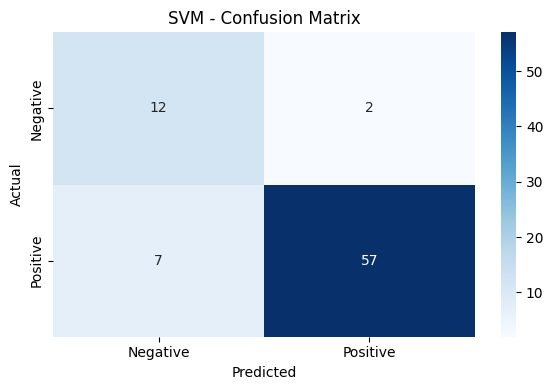

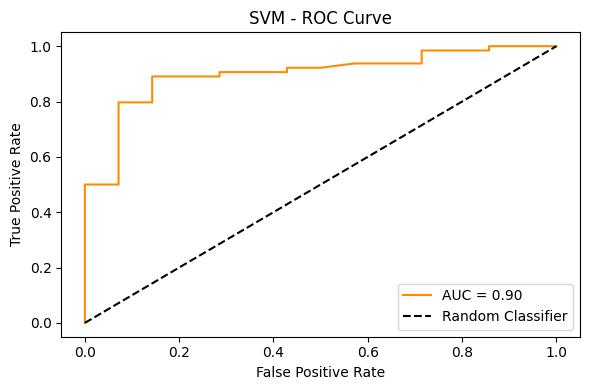

Best Hyperparameters:
   • C: 10
   • coef0: 1.0
   • degree: 4
   • gamma: auto
   • kernel: poly




In [72]:
target_names = ['Negative', 'Positive']

for name, model in models.items():
    print("~" * 90)
    print(f"🔍 Model: {name}")
    print("~" * 90)

    # predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"📊 Accuracy     : {acc:.4f}")
    print(f"📊 F1 Score     : {f1:.4f}")
    print(f"📊 ROC AUC      : {roc_auc:.4f}")

    # classification report
    print("\n📄 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # hyperparameters
    print("Best Hyperparameters:")
    for param, val in model.best_params_.items():
        print(f"   • {param}: {val}")

    print("\n")

**Random Forest**
<br>
<br>
The Random Forest model performed really well in predicting customer feedback. It reached **88% accuracy**, meaning it got most predictions right. Its **F1 Score of 0.93** shows that the model is especially good at handling both precision (how many predicted positives were correct) and recall (how many actual positives were caught).
<br>
<br>
Looking at the **confusion matrix**, it correctly predicted 60 positive feedbacks and 9 negative ones, with only a few mistakes. The **ROC curve** also looks great, with an **AUC of 0.89**, meaning the model is good at distinguishing between positive and negative feedback.
<br>
<br>
In short, this model doesn't just predict well overall, it also performs reliably across both classes, which is important because our data was imbalanced.
___
**XGBoost**
<br>
<br>
The XGBoost model also showed strong performance in predicting customer feedback. It achieved an **accuracy of 85%**, which means it got the majority of predictions correct. The **F1 Score of 0.90** suggests the model does a great job balancing precision and recall—especially helpful when the dataset is imbalanced like ours.
<br>
<br>
From the **confusion matrix**, we can see the model correctly identified 56 positive feedbacks and 10 negative ones. Although it misclassified a few more positives compared to Random Forest, it still managed solid results. The **ROC AUC score of 0.88** confirms that the model is very good at telling the difference between positive and negative feedback.
<br>
<br>
Overall, XGBoost is a powerful model that handles complexity well and delivers high-quality predictions, even with challenging data like this.
___
**Logistic Regression**
<br>
<br>
The Logistic Regression model performed quite well in predicting customer feedback. It reached an **accuracy of 87%**, meaning it got most predictions right. With an **F1 Score of 0.92**, the model shows strong balance between precision (how many predicted positives were correct) and recall (how many actual positives were correctly identified).
<br>
<br>
From the **confusion matrix**, the model correctly predicted **57 positive** and **11 negative** feedbacks, while misclassifying 7 actual positives and 3 actual negatives. The **ROC curve** is solid too, with an **AUC score of 0.87**, showing it can distinguish well between the two classes.
<br>
<br>
In short, Logistic Regression gives reliable performance overall, especially in handling imbalanced data where one class dominates.

___

**K-Nearest Neighbors (KNN)**
<br>
<br>
The KNN model also showed strong results, achieving an **accuracy of 86%**. Its **F1 Score of 0.92** reflects good precision and recall, in which is important when working with imbalanced datasets.
<br>
<br>
Looking at the **confusion matrix**, it correctly predicted **61 positive** and **6 negative** feedbacks, though it misclassified 3 actual positives and 8 actual negatives. The **AUC score of 0.82** from the ROC curve suggests it's reasonably effective in distinguishing between the classes, although slightly weaker than Logistic Regression in that aspect. <br>
<br>
Overall, KNN is a solid performer for this task, but it tends to struggle a bit more with identifying negative feedbacks correctly.

___

**Support Vector Machine (SVM)**
<br>
<br>
The SVM model delivered the best performance among the three. It achieved an **accuracy of 88%**, meaning it correctly predicted the majority of the samples. Its **F1 Score of 0.93** highlights strong precision and recall, which is essential for imbalanced data.
<br>
<br>
Based on the **confusion matrix**, the model correctly predicted **57 positive** and **12 negative** feedbacks, with minimal misclassifications. The **ROC AUC score of 0.90** shows excellent ability to distinguish between positive and negative classes.
<br>
<br>
In summary, SVM proved to be the most robust model in this comparison, delivering high accuracy, excellent class balance, and strong separation capability between classes.


# **Comparison**

In [69]:
print("Model Performance Comparison:\n")

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # get probability for class 1 (positive)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)

    print(f"{name:<20} → Accuracy: {acc:.4f} | F1 Score: {f1:.4f} | ROC AUC: {auc_score:.4f}")

Model Performance Comparison:

Random Forest        → Accuracy: 0.8846 | F1 Score: 0.9302 | ROC AUC: 0.8884
XGBoost              → Accuracy: 0.8462 | F1 Score: 0.9032 | ROC AUC: 0.8817
Logistic Regression  → Accuracy: 0.8718 | F1 Score: 0.9194 | ROC AUC: 0.8733
KNN                  → Accuracy: 0.8590 | F1 Score: 0.9173 | ROC AUC: 0.8175
SVM                  → Accuracy: 0.8846 | F1 Score: 0.9268 | ROC AUC: 0.8990


**Best Overall Model:**

Based on both **F1 Score** and **ROC AUC**, `Support Vector Machine (SVM)` stands out as the most balanced and reliable model. It matches `Random Forest` in accuracy (88.46%), has a slightly lower F1 Score (0.9268 vs. 0.9302), but it has the highest ROC AUC (0.8990). This indicates SVM is slightly better at distinguishing between classes, which is especially important for imbalanced data.

* **Random Forest Strengths:**
  It delivers the highest F1 Score (0.9302), which suggests excellent precision and recall. However, its ROC AUC is slightly lower than SVM.

* **XGBoost Observation:**
  While powerful, XGBoost shows slightly lower scores across all three metrics compared to Random Forest and SVM. Still solid, but not the top performer here.

* **Logistic Regression and KNN:**
  Both perform well, but they fall slightly behind SVM and Random Forest. KNN particularly shows a lower ROC AUC (0.8175), meaning its class separation isn’t as strong.


# **Conculsion**

In [79]:
best_model = models["SVM"].best_estimator_

In [80]:
print(models["SVM"].best_params_)

{'C': 10, 'coef0': 1.0, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}


* **`C: 10`**
  The model focuses more on making correct predictions rather than keeping things simple. A higher C usually means stricter fitting to the training data.

* **`coef0: 1.0`**
  This adds extra weight to certain parts of the formula when using the polynomial kernel. It helps the model shape the boundary better.

* **`degree: 4`**
  The model uses a 4th-degree polynomial to separate the classes. This means it can handle more complex patterns in the data, not just straight lines.

* **`gamma: 'auto'`**
  Gamma controls how much influence each training example has. With `auto`, it uses a standard value based on how many features you have.

* **`kernel: 'poly'`**
  This tells the model to use a polynomial formula to make predictions. It's good for cases where data isn't separated by a simple straight line.

From the results, the SVM model with these hyperparameters gave the **best balance of accuracy, F1 score, and ROC AUC** compared to the other models. This means it was the most reliable in predicting both positive and negative feedback.

* The model used a **4th-degree polynomial kernel**. This helped the SVM model handle **data that isn’t just split by a straight line**, but may have more complex patterns.
* With **C = 10**, the model aimed to get as many predictions correct as possible, even if the decision boundary becomes more complex.
* The combination of C, degree, and other settings helped the model perform well:
  **88.46% accuracy**, **0.9268 F1 Score**, and **0.8990 ROC AUC**.
  This means the model not only predicted most samples correctly, but also maintained a good balance between catching positive and negative feedbacks.

In short:

The SVM model is a **strong choice** here because it can handle complex feedback patterns, predicts well on both classes, and gives consistently high evaluation scores. It's especially useful when simple models like logistic regression don't fully capture the data's behavior.


In [81]:
import joblib
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']